In [1]:
import numpy as np
from numpy.random import default_rng
rng = default_rng()
import matplotlib.pyplot as plt
import ipywidgets as widgets  # interactive display


%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.style.use("../JC.mplstyle")


In [2]:
def plot_strategy(ax, time_steps, average_reward, optimal_action):
  ax[0].plot(np.arange(time_steps), average_reward, linewidth=1)
  ax[0].set_ylabel('Average Reward')
  ax[0].set_xlabel("Steps")
  ax[1].plot(np.arange(time_steps),optimal_action, linewidth=1)
  ax[1].set_ylabel("Optimal Action (%)")
  ax[1].set_ylim([0, 1])
  ax[1].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
  ax[1].set_xlabel("Steps")


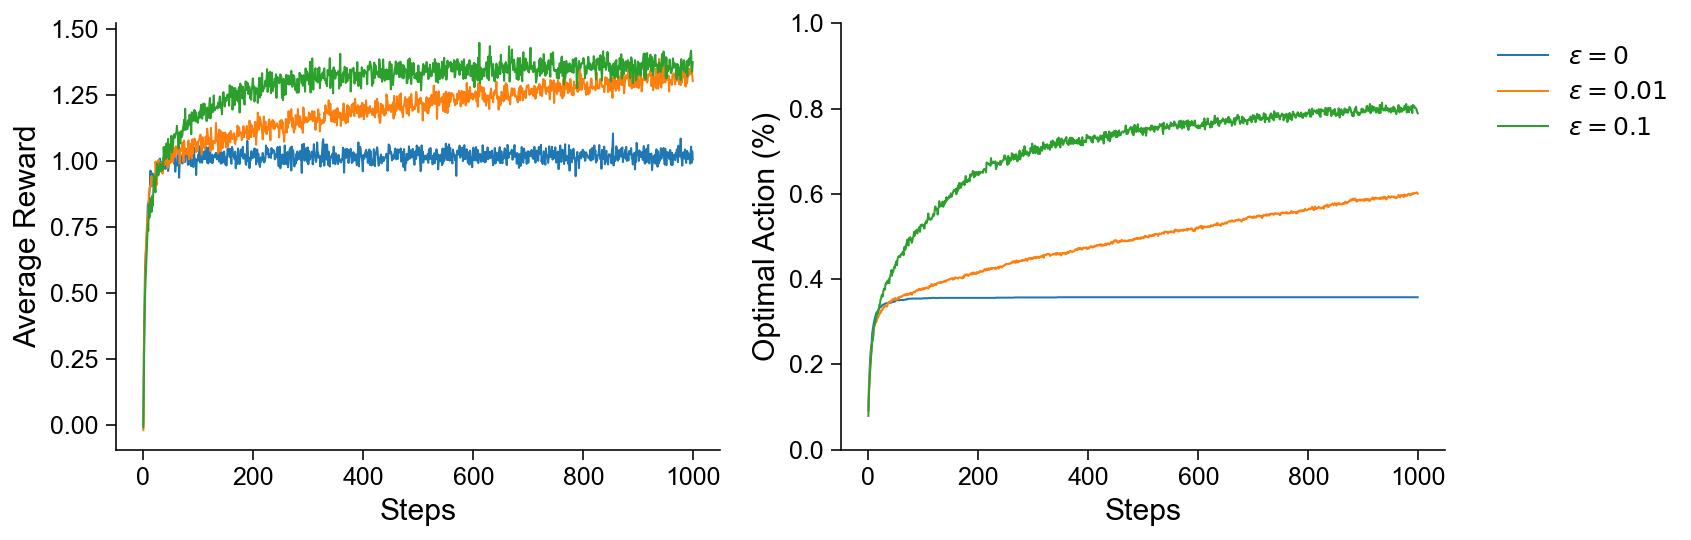

In [3]:
# 10-armed testbed
epsilon_list = [0, 0.01, 0.1]
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
for epsilon in epsilon_list:
    set_size =  2000
    k_arm = 10
    time_steps = 1000
    Total_reward = []
    Total_optimal = []
    for i_set in range(set_size):
        q = rng.standard_normal(size=k_arm)
        optimal_action = np.argmax(q)
        action_count = np.zeros(k_arm)
        q_est = np.zeros(k_arm)
        reward_list = []
        optimal_list = []
        for i_step in range(time_steps):
            
            if rng.random() < epsilon:
                action = rng.integers(low=0, high=k_arm)
                optimal_list.append(action==optimal_action)
            else:
                action = rng.choice(np.flatnonzero(q_est == q_est.max()))
                optimal_list.append(action==optimal_action)

            action_count[action] += 1
            reward = rng.normal(loc=q[action], scale=1)
            reward_list.append(reward)
            q_est[action] += (reward - q_est[action])/action_count[action]
        
        
        Total_reward.append(reward_list)
        Total_optimal.append(optimal_list)
    Total_reward = np.array(Total_reward)
    Total_optimal = np.array(Total_optimal)
    Average_reward = np.mean(Total_reward,axis=0)
    Average_optimal = np.mean(Total_optimal,axis=0)
    plot_strategy(ax, time_steps, Average_reward, Average_optimal)

plt.legend([r'$\epsilon=0$',r'$\epsilon=0.01$',r'$\epsilon=0.1$'], bbox_to_anchor = (1.05, 1.0), loc="upper left")
plt.show()

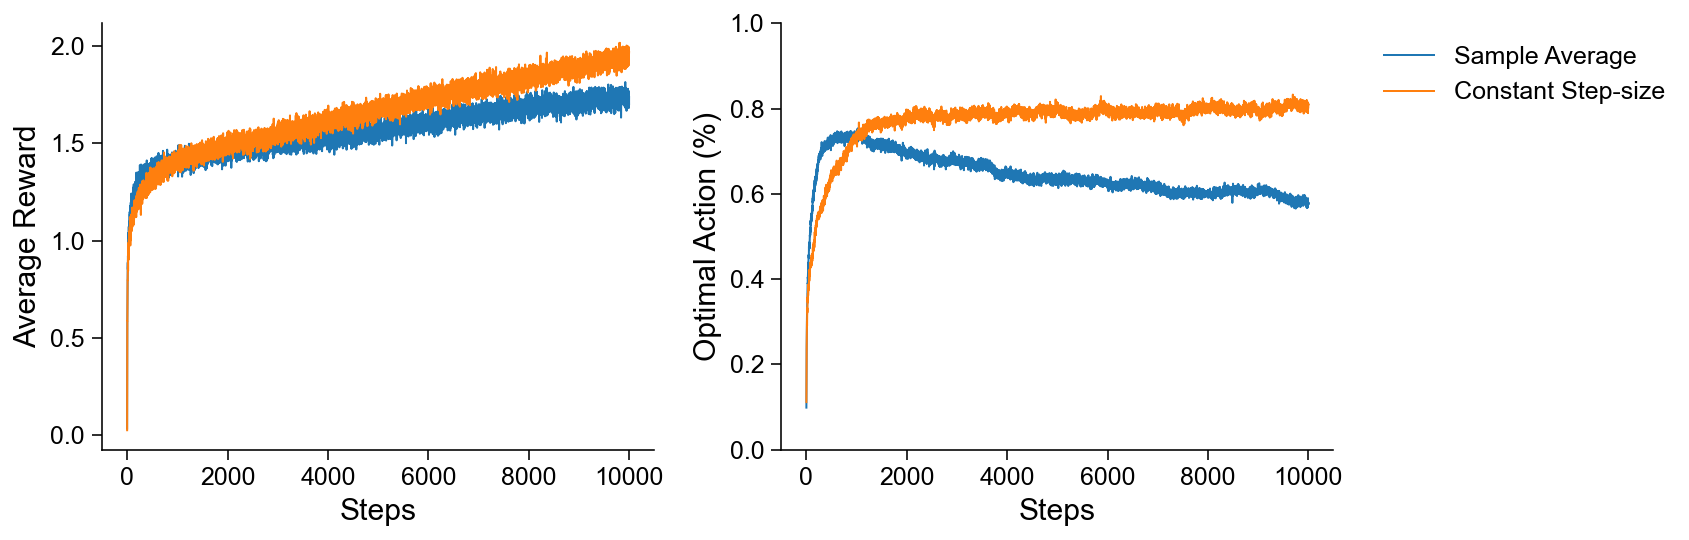

In [4]:
# a non-stationary problem
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
for stategy in range(2):
    alpha = 0.1
    epsilon = 0.1
    set_size =  2000
    k_arm = 10
    time_steps = 10000
    Total_reward = []
    Total_optimal = []
    for i_set in range(set_size):
        q = rng.standard_normal(size=k_arm)
        action_count = np.zeros(k_arm)
        q_est = np.zeros(k_arm)
        reward_list = []
        optimal_list = []
        
        for i_step in range(time_steps):
            q += rng.normal(loc=0, scale=0.01, size=k_arm)
            optimal_action = np.argmax(q)

            if rng.random() < epsilon:
                action = rng.integers(low=0, high=k_arm)
                optimal_list.append(action==optimal_action)
            else:
                action = rng.choice(np.flatnonzero(q_est == q_est.max()))
                optimal_list.append(action==optimal_action)

            action_count[action] += 1
            reward = rng.normal(loc=q[action], scale=1)
            reward_list.append(reward)
            if stategy == 0:
                q_est[action] += (reward - q_est[action])/action_count[action]
            else:
                q_est[action] += (reward - q_est[action])*alpha
            

        Total_reward.append(reward_list)
        Total_optimal.append(optimal_list)

            
    Total_reward = np.array(Total_reward)
    Total_optimal = np.array(Total_optimal)
    Average_reward = np.mean(Total_reward,axis=0)
    Average_optimal = np.mean(Total_optimal,axis=0)
    plot_strategy(ax, time_steps, Average_reward, Average_optimal)
    
plt.legend(["Sample Average", 'Constant Step-size'], bbox_to_anchor = (1.05, 1.0), loc="upper left")
plt.show()

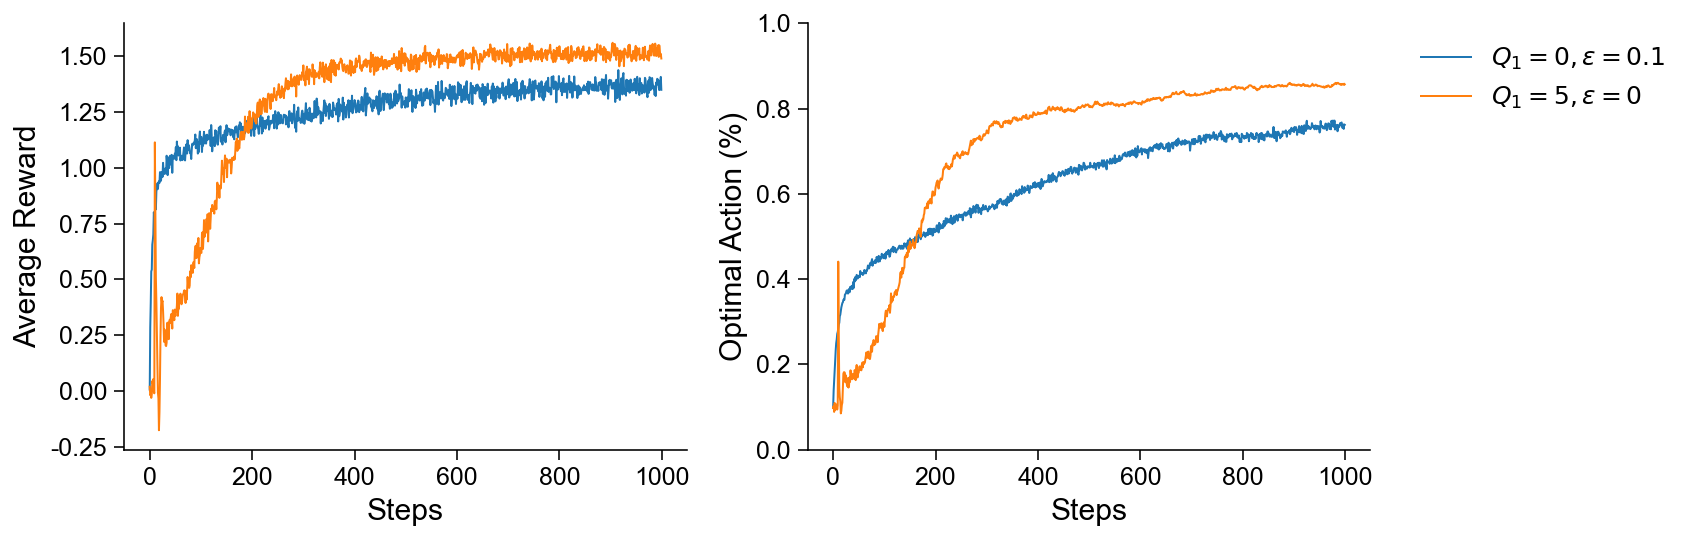

In [5]:
# a non-stationary problem
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
for stategy in range(2):
    alpha = 0.1
    set_size =  2000
    k_arm = 10
    time_steps = 1000
    Total_reward = []
    Total_optimal = []
    for i_set in range(set_size):
        q = rng.standard_normal(size=k_arm)
        optimal_action = np.argmax(q)
        action_count = np.zeros(k_arm)

        if stategy == 0:
            q_est = np.zeros(k_arm)
            epsilon = 0.1
        else:
            q_est = np.ones(k_arm)*5
            epsilon = 0
                
        reward_list = []
        optimal_list = []

        for i_step in range(time_steps):

            if rng.random() < epsilon:
                action = rng.integers(low=0, high=k_arm)
                optimal_list.append(action==optimal_action)
            else:
                action = rng.choice(np.flatnonzero(q_est == q_est.max()))
                optimal_list.append(action==optimal_action)

            action_count[action] += 1
            reward = rng.normal(loc=q[action], scale=1)
            reward_list.append(reward)
            q_est[action] += (reward - q_est[action])*alpha
            

        Total_reward.append(reward_list)
        Total_optimal.append(optimal_list)

            
    Total_reward = np.array(Total_reward)
    Total_optimal = np.array(Total_optimal)
    Average_reward = np.mean(Total_reward,axis=0)
    Average_optimal = np.mean(Total_optimal,axis=0)
    plot_strategy(ax, time_steps, Average_reward, Average_optimal)
    
plt.legend([r'$Q_{1}=0,\epsilon=0.1$', r'$Q_{1}=5,\epsilon=0$'], bbox_to_anchor = (1.05, 1.0), loc="upper left")
plt.show()